(15, 15)


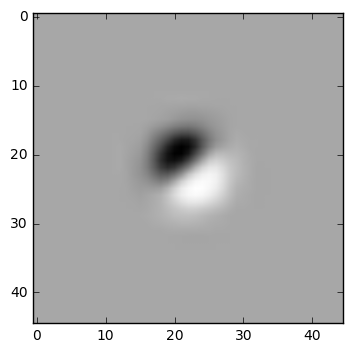

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from numpy.random import rand, randn

def getRandomGaborParams(size):
    
    theta = np.pi*(2*rand() - 1)
    psi = np.pi*rand()
    sigma = 3*np.abs(randn()) + 10e-3
    lambd = 5*np.abs(randn()) + 10e-3
    gamma = np.pi*rand()
    return {'ksize':size, 'sigma':sigma, 'theta': theta, 'lambd':lambd, 'gamma':gamma, 'psi': psi}
    

# cv2.getGaborKernel(ksize, sigma, theta, lambda, gamma, psi, ktype)
# ksize - size of gabor filter (n, n)
# sigma - standard deviation of the gaussian function
# theta - orientation of the normal to the parallel stripes
# lambda - wavelength of the sunusoidal factor
# gamma - spatial aspect ratio
# psi - phase offset
# ktype - type and range of values that each pixel in the gabor kernel can hold

params = getRandomGaborParams((15,15))
g_kernel = cv2.getGaborKernel(**params)
print(g_kernel.shape)

img = cv2.imread('cat.jpg',0)
filtered_img = cv2.filter2D(img, cv2.CV_32F, g_kernel)

h, w = g_kernel.shape[:2]
g_show = cv2.resize(g_kernel, (3*w, 3*h), interpolation=cv2.INTER_CUBIC)
plt.imshow(g_show, cmap='Greys')
plt.show()

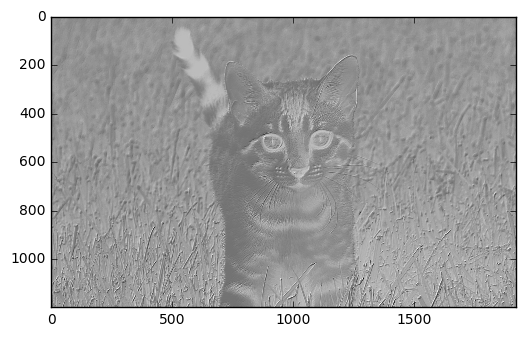

In [4]:
plt.imshow(filtered_img, cmap='Greys')
plt.show()

## My Gabor filter implementation

 Parameters
    ----------
    frequency : float
        Spatial frequency of the harmonic function. Specified in pixels.
    theta : float, optional
        Orientation in radians. If 0, the harmonic is in the x-direction.
    bandwidth : float, optional
        The bandwidth captured by the filter. For fixed bandwidth, `sigma_x`
        and `sigma_y` will decrease with increasing frequency. This value is
        ignored if `sigma_x` and `sigma_y` are set by the user.
    sigma_x, sigma_y : float, optional
        Standard deviation in x- and y-directions. These directions apply to
        the kernel *before* rotation. If `theta = pi/2`, then the kernel is
        rotated 90 degrees so that `sigma_x` controls the *vertical* direction.
    n_stds : scalar, optional
        The linear size of the kernel is n_stds (3 by default) standard
        deviations
    offset : float, optional
        Phase offset of harmonic function in radians.

In [5]:
def myGaborKernel(size = 9, frequency = 1, theta=0, sigma_x=5, sigma_y=5, psi=0):

    x0 = np.ceil(max(size/2, 1))
    y0 = np.ceil(max(size/2, 1))
    print(x0,y0)
    y, x = np.mgrid[-y0+1:y0, -x0+1:x0]

    rotx = x * np.cos(theta) + y * np.sin(theta)
    roty = -x * np.sin(theta) + y * np.cos(theta)

    g = np.zeros(y.shape, dtype=np.complex)
    g[:] = np.exp(-0.5 * (rotx ** 2 / sigma_x ** 2 + roty ** 2 / sigma_y ** 2))
    #g /= 2 * np.pi * sigma_x * sigma_y
    g *= np.exp(1j * (2 * np.pi * frequency * rotx + psi))
    
    return g

C:\Users\User\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


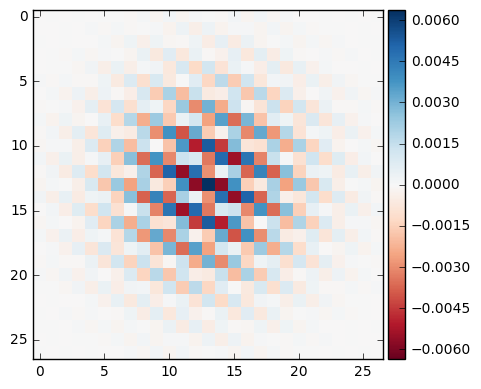

In [6]:

>>> from skimage.filters import gabor_kernel
>>> from skimage import io
>>> from matplotlib import pyplot as plt  # doctest: +SKIP
>>> gk = gabor_kernel(frequency=0.8, sigma_x = 5, sigma_y = 5, theta=1)
>>> plt.figure()        # doctest: +SKIP
>>> io.imshow(gk.real)  # doctest: +SKIP
>>> io.show()           # doctest: +SKIP

In [12]:
np.std(gk.real)

0.0014773750491777018

14.0 14.0


C:\Users\User\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


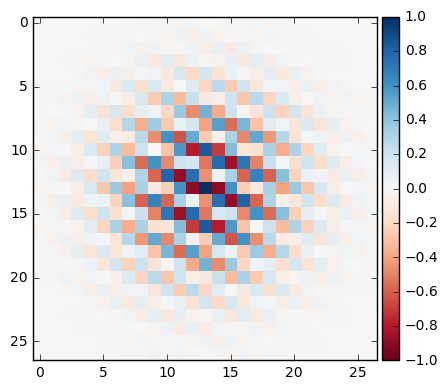

In [8]:
gkm = myGaborKernel(frequency=0.8, sigma_x = 5, sigma_y = 5, theta=1, size = 27)
plt.figure()        # doctest: +SKIP
io.imshow(gkm.real)  # doctest: +SKIP
io.show()

In [13]:
np.std(gkm.real)

0.23206553005467642

# Torch implementation

In [16]:
import torch.nn as nn
import torch
from torch.autograd import Variable

In [272]:
import torch
from torch.nn.parameter import Parameter
from torch.nn import functional as F
from torch.nn.modules.conv import _ConvNd
from torch.nn.modules.utils import _pair

class MyGabor(_ConvNd):
    
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=False):
        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)
        
        super(MyGabor, self).__init__(in_channels, out_channels, kernel_size, stride, padding, dilation,False, _pair(0), groups, bias)
        
        # TODO: подумать над инициализацией параметров
        self.sigma_x = nn.Parameter(kernel_size[0]/3*torch.rand(in_channels,out_channels))
        self.sigma_y = nn.Parameter(kernel_size[0]/3*torch.rand(in_channels,out_channels))
        self.freq = nn.Parameter(kernel_size[0]*torch.rand(in_channels,out_channels))
        self.theta = nn.Parameter(3.14*torch.rand(in_channels,out_channels))
        self.psi = nn.Parameter(3.14*torch.rand(in_channels,out_channels))
        #self.evaluate = False
    
    #def eval(self):
        #self.evaluate = True
        
    #def train(self):
        #self.evaluate = False
        
    def forward(self, input):
        
        '''if self.evaluate == True:
            return F.conv2d(input, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)'''
        
        x0 = torch.ceil(torch.Tensor([self.kernel_size[0]/2]))[0]
        y0 = torch.ceil(torch.Tensor([self.kernel_size[1]/2]))[0]
        
        weight = torch.empty(self.weight.shape, requires_grad=False)
        for i in range(self.in_channels):
            for j in range(self.out_channels):
                y, x = torch.meshgrid([torch.arange(-y0+1,y0), torch.arange(-x0+1,x0)])
                sigma_x = self.sigma_x[i,j].expand_as(y)
                sigma_y = self.sigma_y[i,j].expand_as(y)
                freq = self.freq[i,j].expand_as(y)
                theta = self.theta[i,j].expand_as(y)
                psi = self.psi[i,j].expand_as(y)
                
                rotx = x * torch.cos(theta) + y * torch.sin(theta)
                roty = -x * torch.sin(theta) + y * torch.cos(theta) 
                g = torch.zeros(y.shape)
                g = torch.exp(-0.5 * (rotx ** 2 / (sigma_x + 1e-3) ** 2 + roty ** 2 / (sigma_y + 1e-3) ** 2))
                g = g * torch.cos(2 * 3.14 * freq * rotx + psi) / (2*3.14*sigma_x*sigma_y)
                weight[j,i] = g
                self.weight.data[j,i] = g    
        return F.conv2d(input, weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

In [273]:
model = MyGabor(1,3,(15,15))
img_t = torch.Tensor((img - np.mean(img))/np.std(img)).unsqueeze(0).unsqueeze(0)

In [274]:
out = model(img_t)

C:\Users\User\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


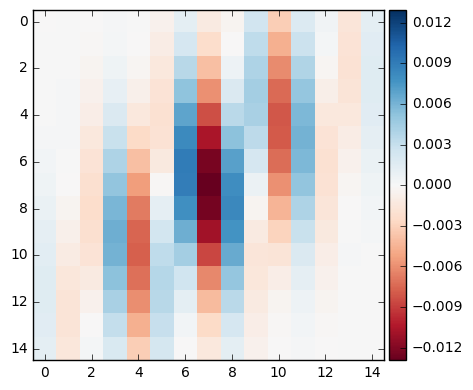

In [277]:
plt.figure()        # doctest: +SKIP
io.imshow(model.weight.detach().numpy()[2,0])  # doctest: +SKIP
io.show()

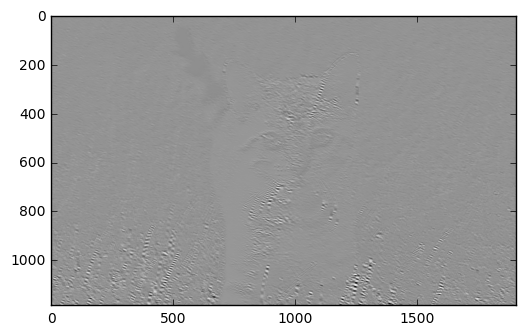

In [278]:
plt.imshow(out.detach().numpy()[0,0], cmap='Greys')
plt.show()

In [250]:
model.theta.grad

In [251]:
loss = F.mse_loss(out, torch.ones(1).expand_as(out))

In [252]:
loss.backward()

In [32]:
out.backward(torch.ones(1).expand_as(out))

In [254]:
model.theta.grad

tensor([[-0.0101, -0.0006, -0.0007]])

## GNet sample

In [279]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from numpy.random import rand, randn
import torchvision.datasets as dset
import torchvision.transforms as transforms

In [282]:
transform = transforms.Compose([transforms.Resize((36,36)), transforms.ToTensor()])

train_set = dset.MNIST(root='', train=True, download=True, transform=transform)
test_set = dset.MNIST(root='', train=False, download=True, transform=transform)

batch_size = 256

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)
print('==>>> total trainning batch number: {}'.format(len(train_loader)))
print('==>>> total testing batch number: {}'.format(len(test_loader)))

==>>> total trainning batch number: 235
==>>> total testing batch number: 40


In [331]:
class Net(nn.Module):
    def __init__(self):
        
        super(Net, self).__init__()
        self.g1 = MyGabor(1, 10, kernel_size=(15,15))
        self.p1 = nn.MaxPool2d(4, stride=1)
        self.c1 = nn.Conv2d(1, 10, kernel_size=(3,3))
        self.p3 = nn.MaxPool2d(4, stride=1)
        self.fc2 = nn.Linear(16*16*10, 10)

    def forward(self, x):
        x = F.relu(self.g1(x))
        x = self.p1(x)
        x = F.relu(self.c1(x))
        x = self.p3(x)
        x = x.view(-1, 16*16*10)
        x = self.fc2(x)
        return x

In [332]:
net = Net()
net

Net(
  (g1): MyGabor(1, 10, kernel_size=(15, 15), stride=(1, 1), bias=False)
  (p1): MaxPool2d(kernel_size=4, stride=1, padding=0, dilation=1, ceil_mode=False)
  (c1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (p3): MaxPool2d(kernel_size=4, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=2560, out_features=10, bias=True)
)

In [330]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0)

for epoch in range(50):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        net.train()
        # get the inputs
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print('[%d] loss: %.3f' %(epoch + 1, running_loss / len(train_loader.dataset)))
    running_loss = 0.0
    '''print((net.g1.theta.grad) , torch.max(net.g1.freq.grad))
    print(torch.max(net.fc2.weight.grad))'''
            
    net.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = net(data)
            test_loss += criterion(output, target) # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

print('Finished Training')

[1] loss: 0.007

Test set: Average loss: 0.0060, Accuracy: 7805/10000 (78%)

[2] loss: 0.005

Test set: Average loss: 0.0037, Accuracy: 8265/10000 (83%)

[3] loss: 0.003

Test set: Average loss: 0.0027, Accuracy: 8501/10000 (85%)

[4] loss: 0.002

Test set: Average loss: 0.0022, Accuracy: 8669/10000 (87%)

[5] loss: 0.002

Test set: Average loss: 0.0020, Accuracy: 8761/10000 (88%)

[6] loss: 0.002

Test set: Average loss: 0.0018, Accuracy: 8832/10000 (88%)

[7] loss: 0.002


KeyboardInterrupt: 

## ConvNet comparison

In [474]:
class ConvNet(nn.Module):
    def __init__(self):
        
        super(ConvNet, self).__init__()
        
        self.c1 = nn.Conv2d(1, 3, kernel_size=(15,15), padding=7)
        self.c2 = nn.Conv2d(3, 5, kernel_size=(15,15), padding=7)
        self.c3 = nn.Conv2d(5, 7, kernel_size=(15,15), padding=7)
        
        self.fc4 = nn.Linear(28*28*7, 10)

    def forward(self, x):
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = F.relu(self.c3(x))
        
        x = x.view(-1, 28*28*7)
        x = self.fc4(x)
        return x

In [475]:
convnet = ConvNet()

In [1]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(convnet.parameters(), lr=0.001, momentum=0.9)

for epoch in range(50):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        convnet.train()
        # get the inputs
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = convnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0
            
            #convnet.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = convnet(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

print('Finished Training')

NameError: name 'nn' is not defined

## Kernel visualization

In [305]:
g1_weights = net.g1.weight

In [306]:
g1_weights.shape

torch.Size([10, 1, 15, 15])

In [320]:
sigma_y = net.g1.sigma_y[0,1].detach().numpy()
sigma_x = net.g1.sigma_x[0,1].detach().numpy()
theta = net.g1.theta[0,1].detach().numpy()
psi = net.g1.psi[0,1].detach().numpy()
freq = net.g1.freq[0,1].detach().numpy()

In [321]:
gkm = myGaborKernel(size = 15, frequency=freq,sigma_x=sigma_x, sigma_y=sigma_y, psi=psi, theta=theta)

8.0 8.0


C:\Users\User\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


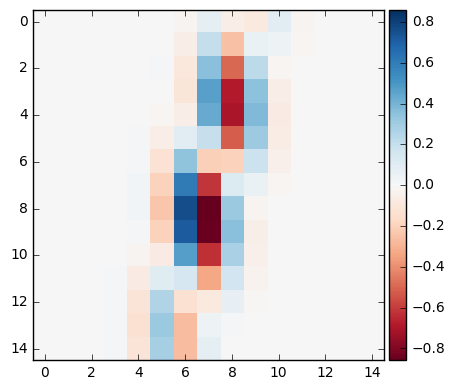

In [322]:
plt.figure()
io.imshow(gkm.real)
io.show()

Gabor


C:\Users\User\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


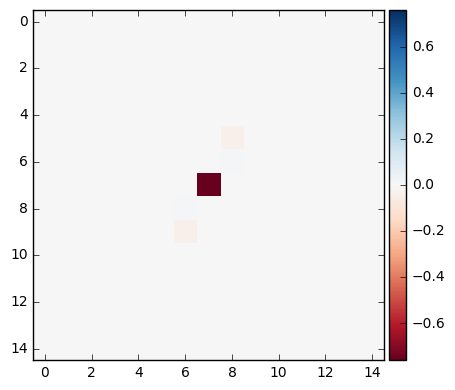

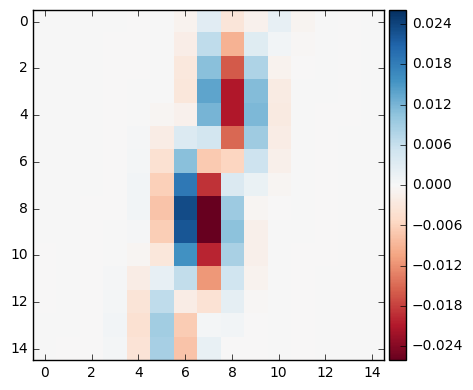

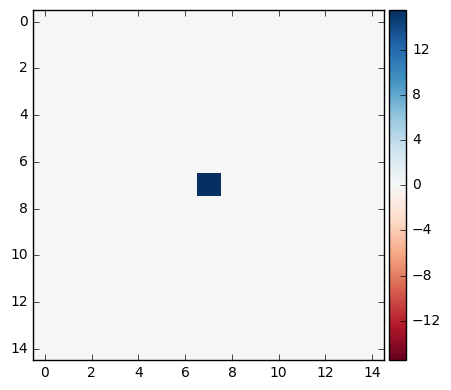

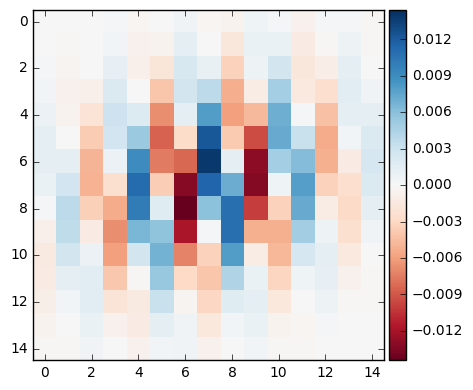

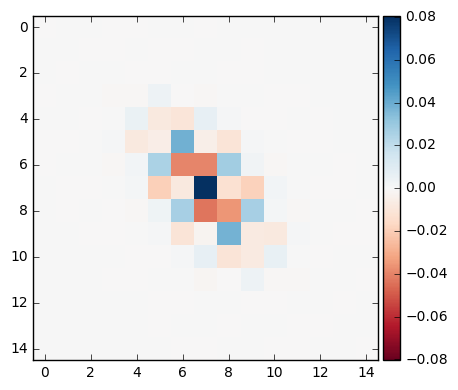

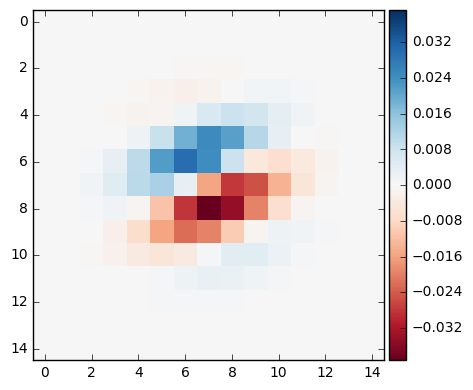

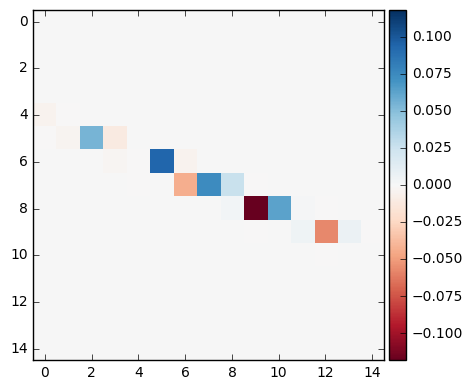

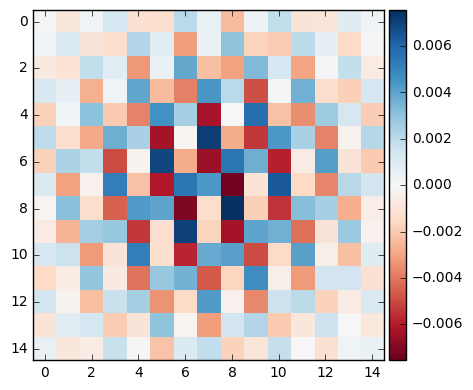

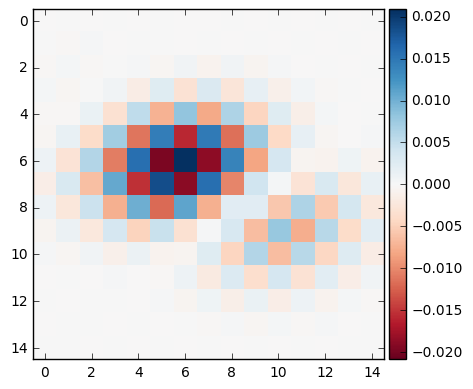

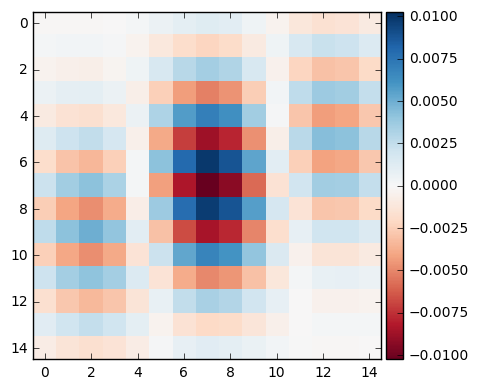

In [308]:
print('Gabor')
for i in range(g1_weights.shape[0]):
    for j in range(g1_weights.shape[1]):
        plt.figure()
        io.imshow(g1_weights[i,j].detach().numpy())
        io.show()

In [311]:
с1_weights = net.c1.weight

Conv


C:\Users\User\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


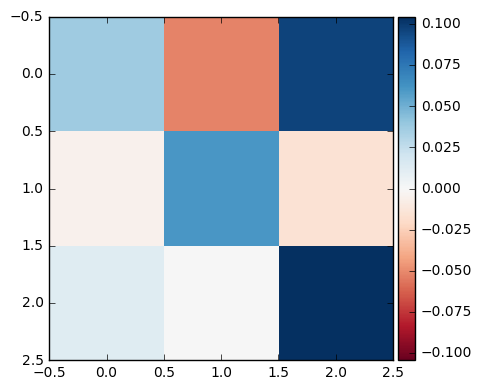

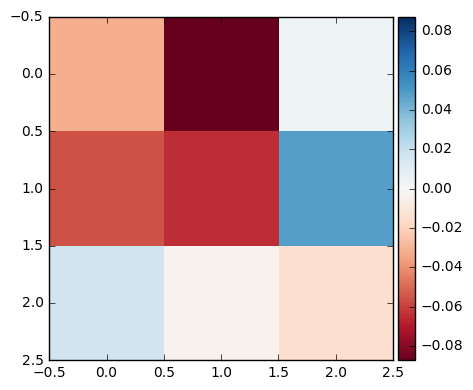

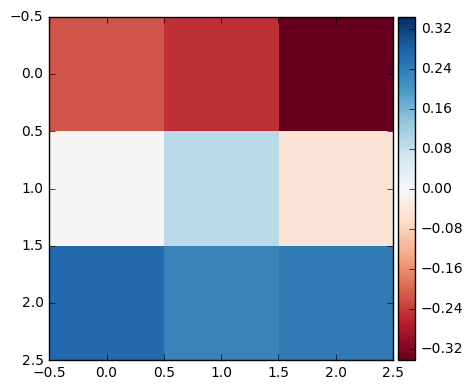

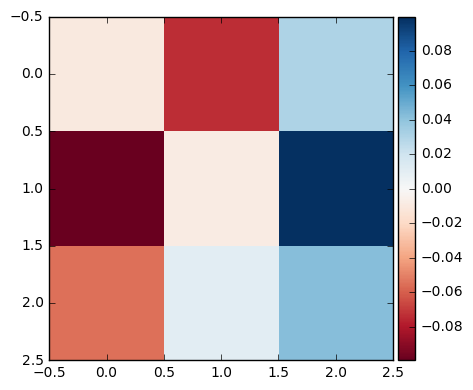

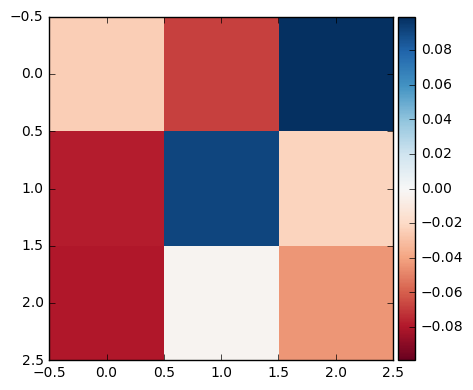

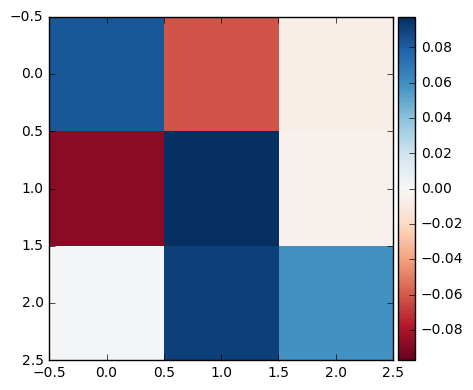

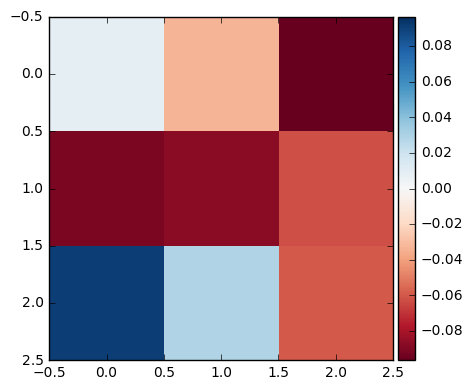

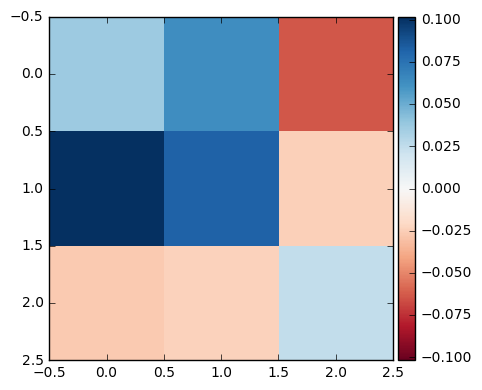

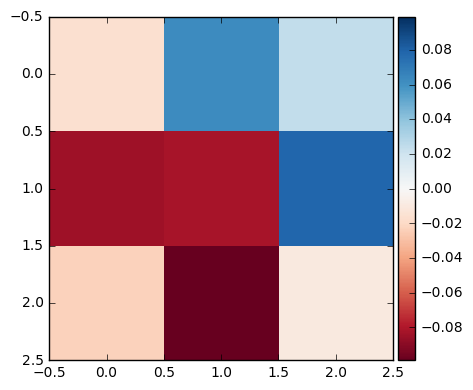

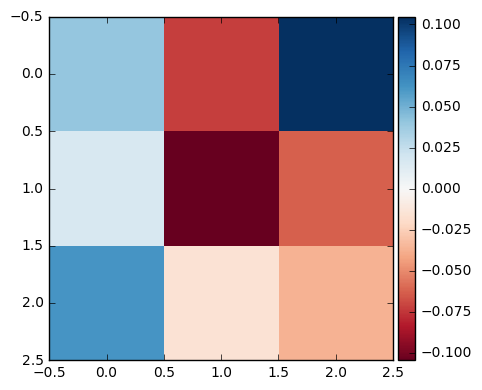

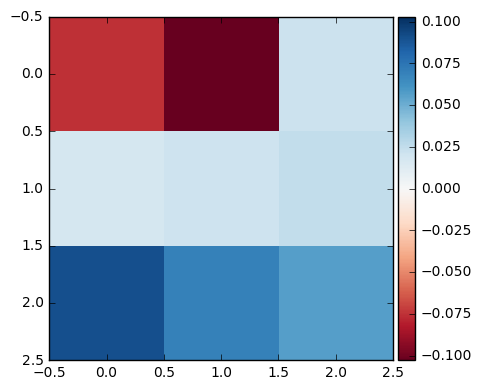

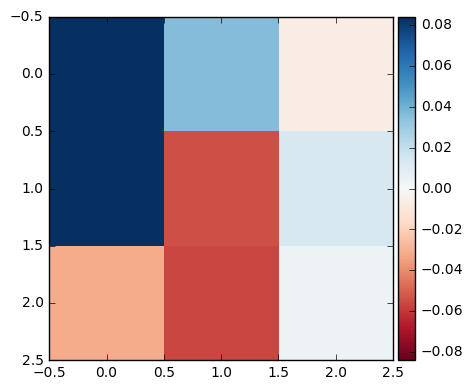

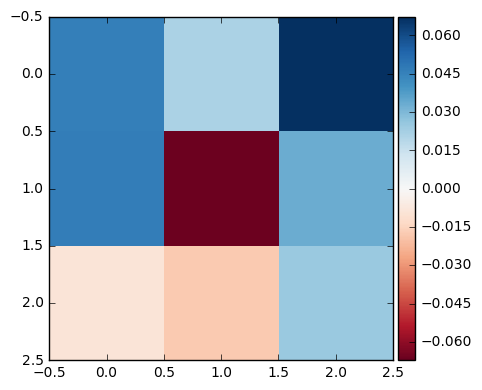

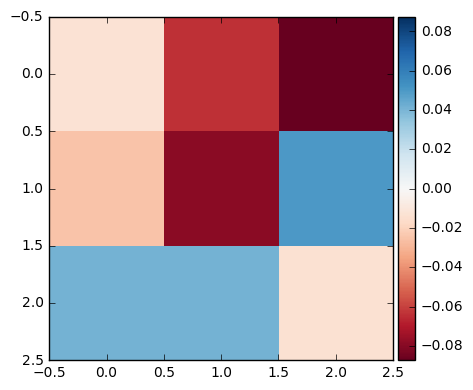

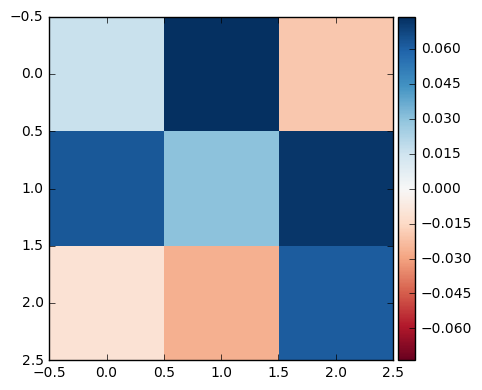

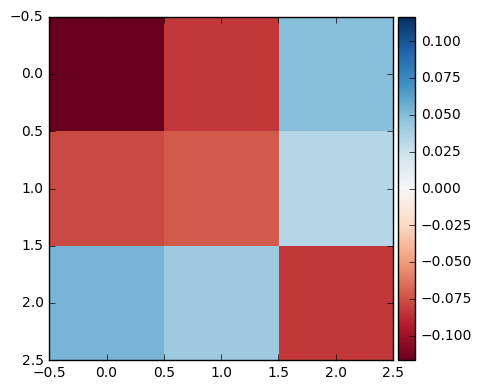

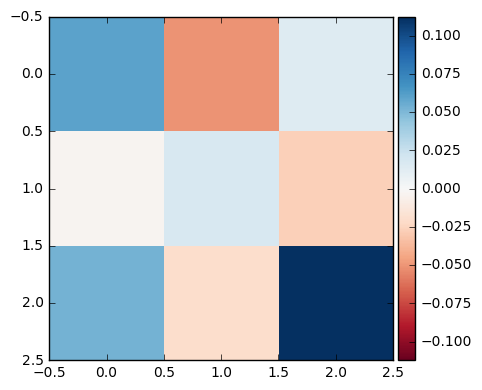

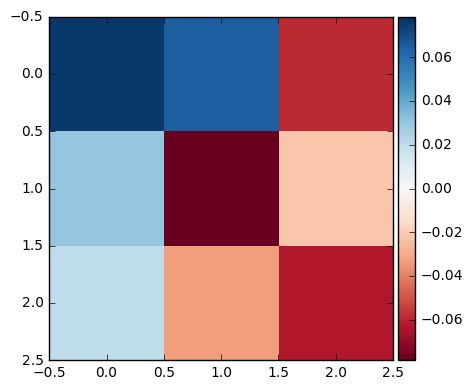

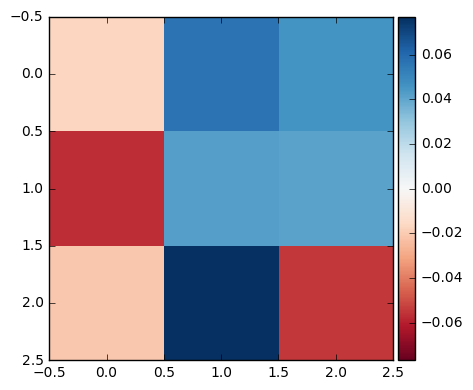

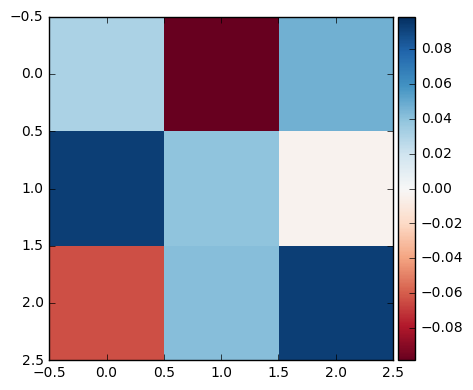

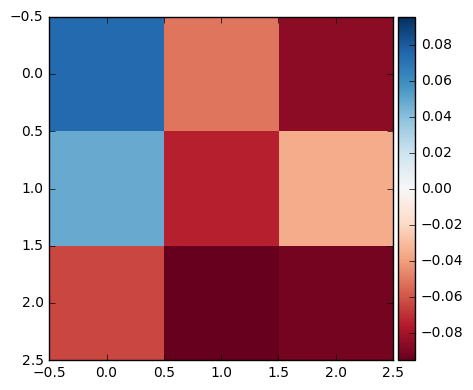

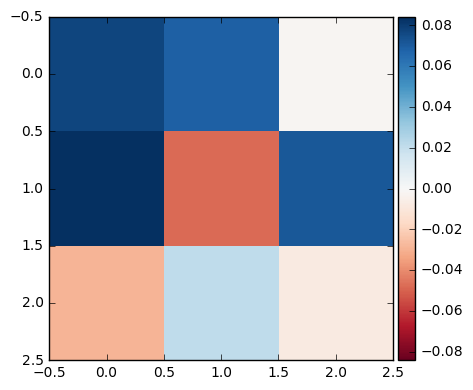

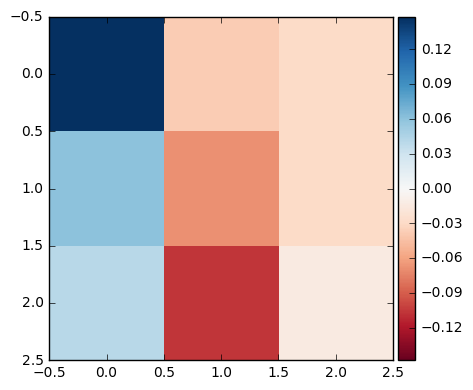

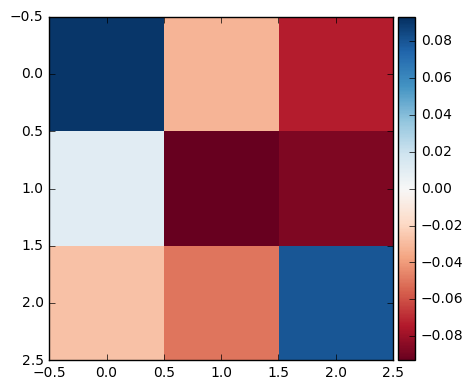

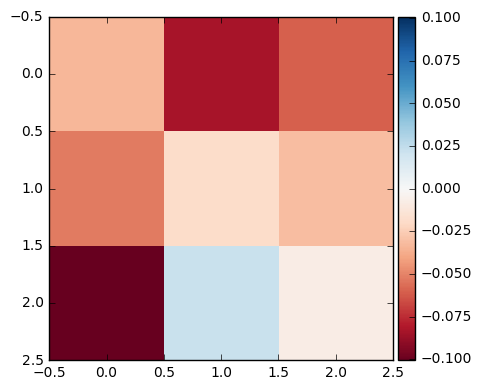

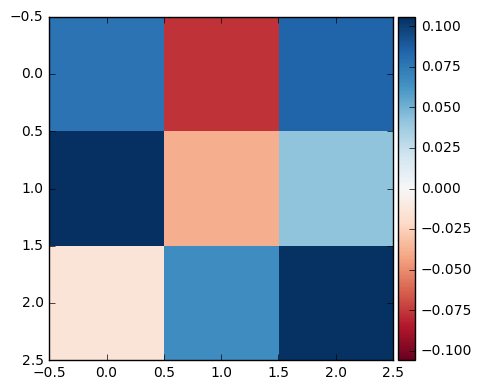

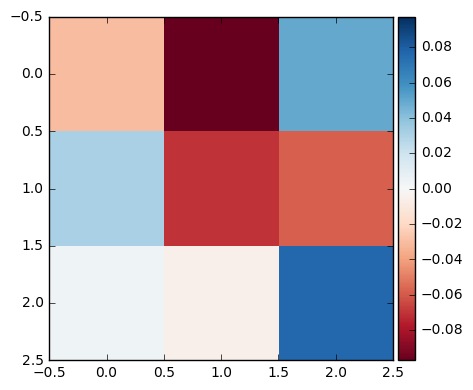

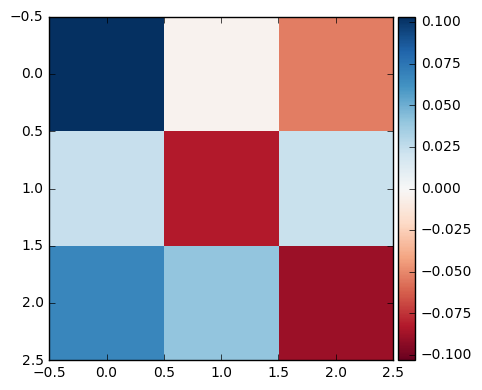

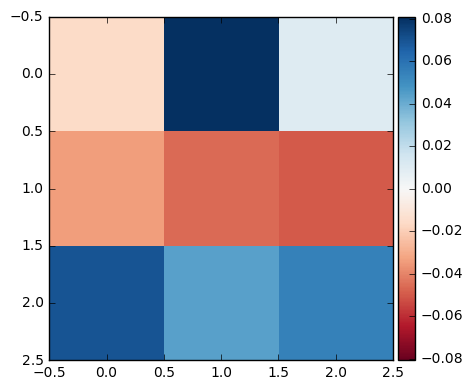

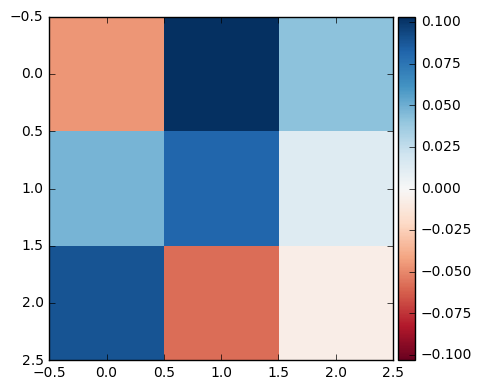

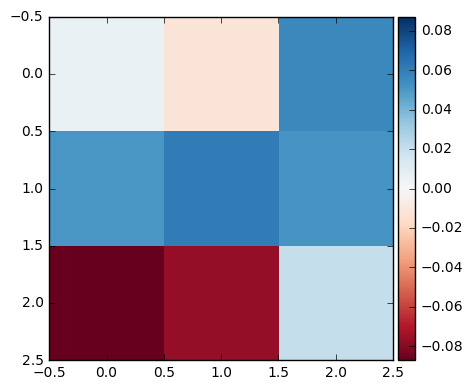

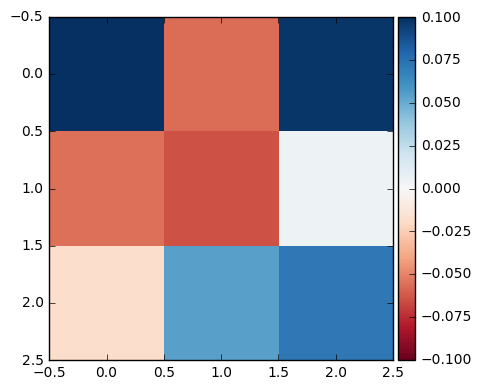

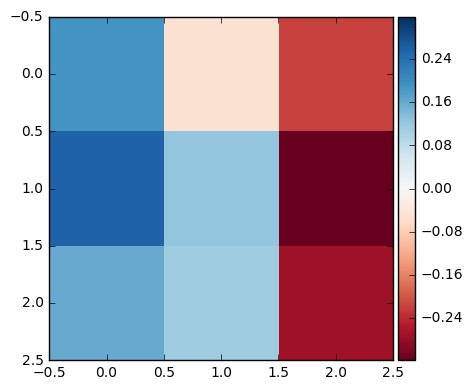

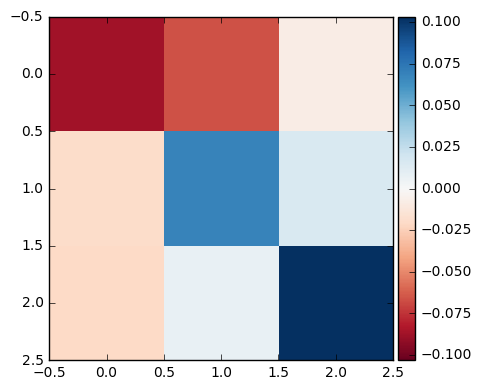

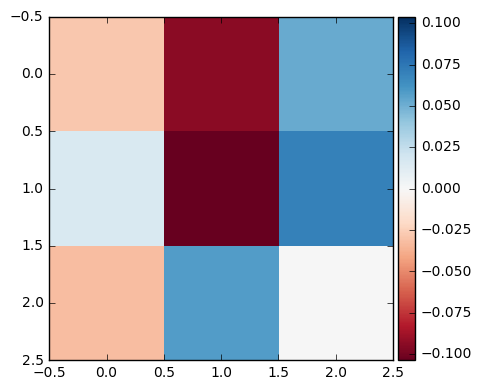

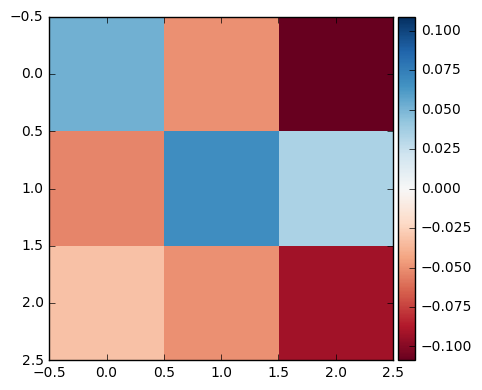

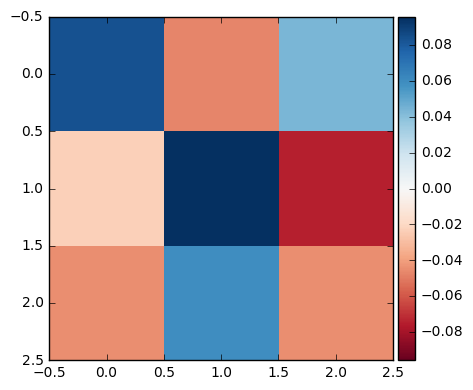

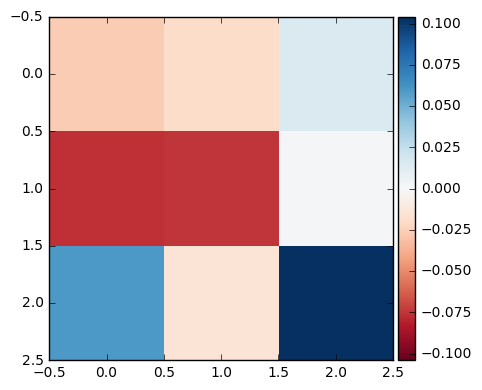

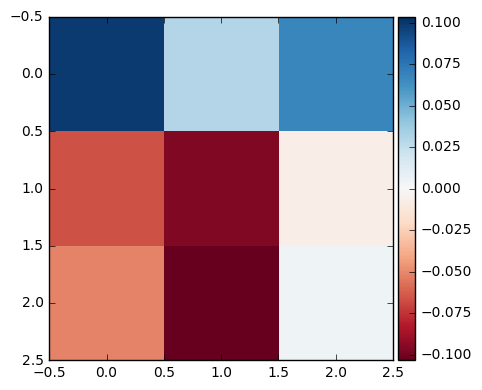

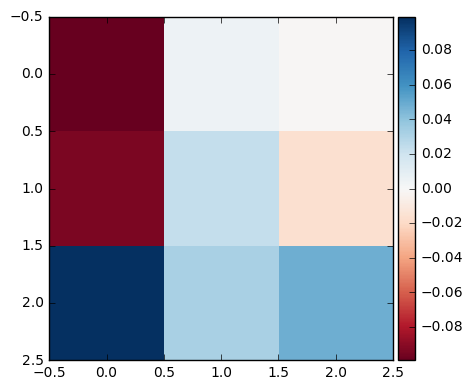

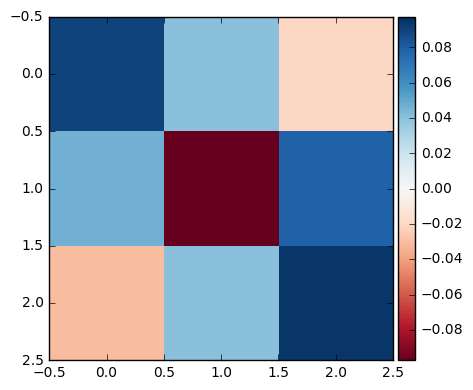

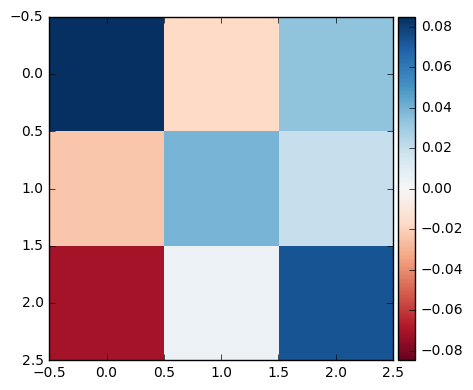

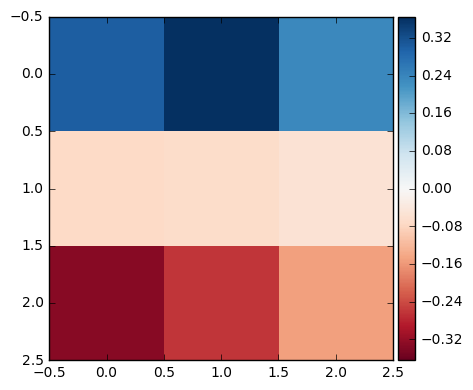

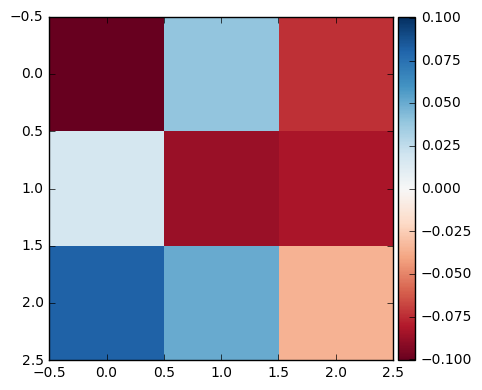

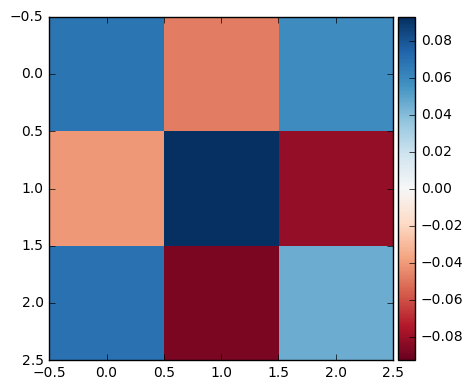

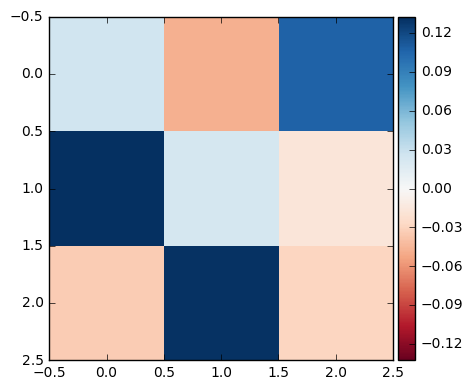

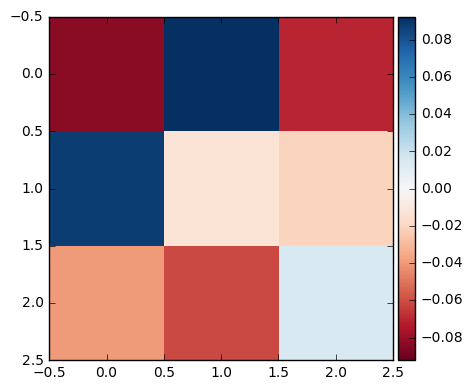

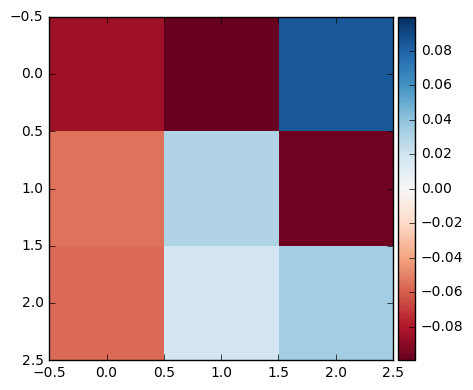

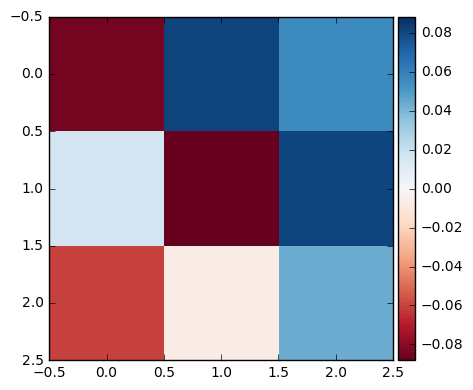

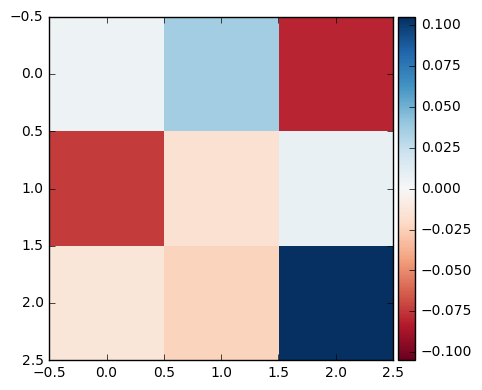

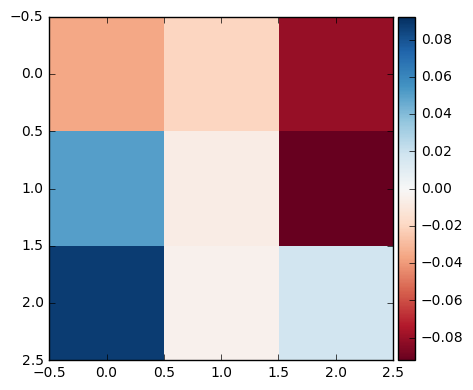

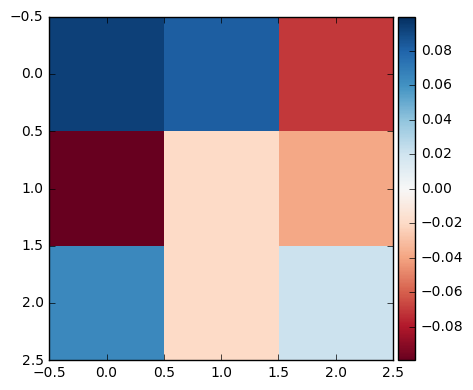

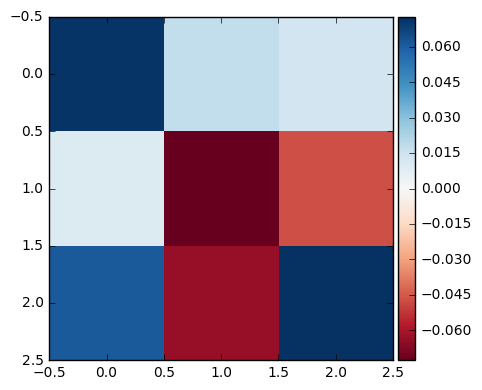

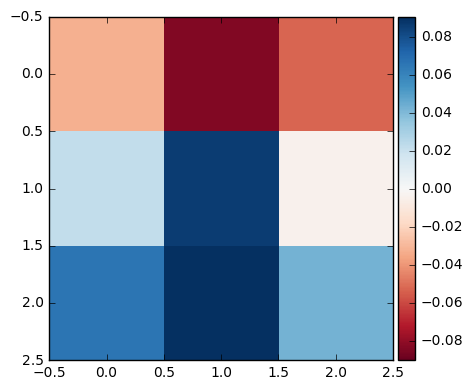

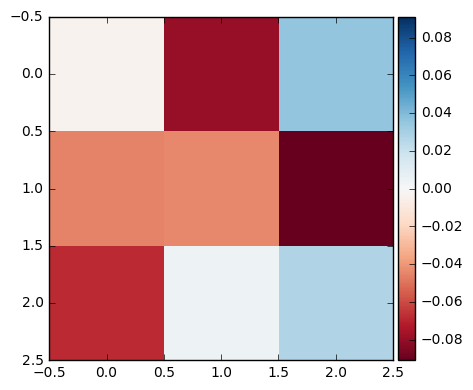

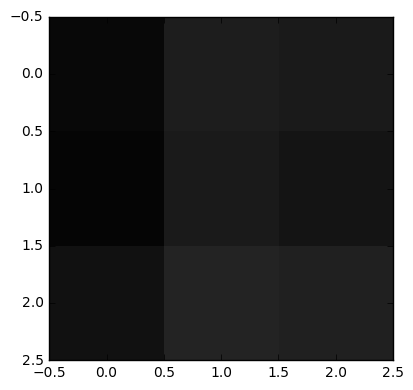

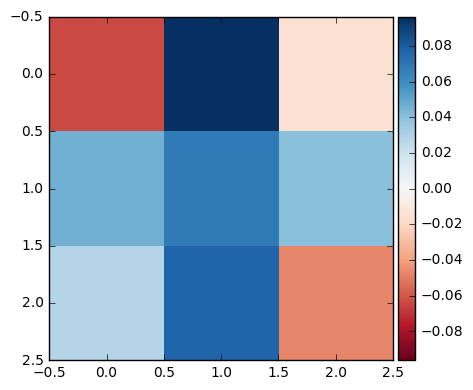

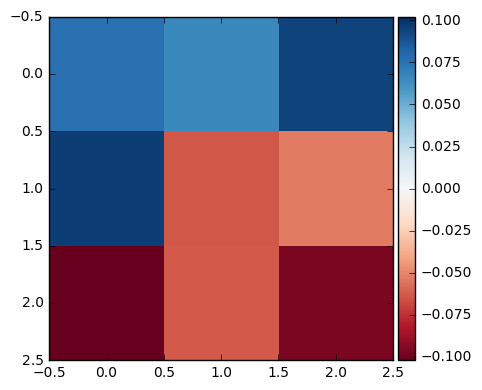

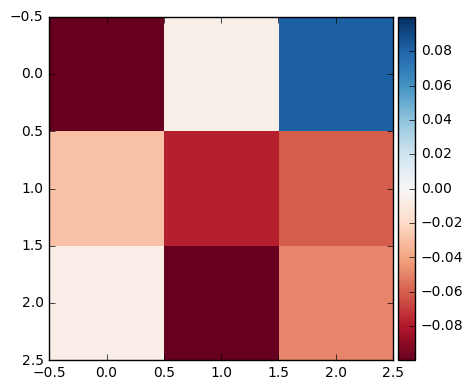

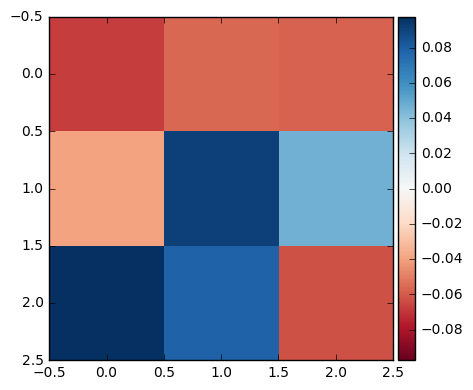

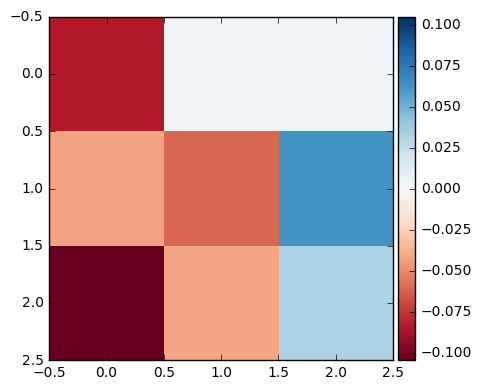

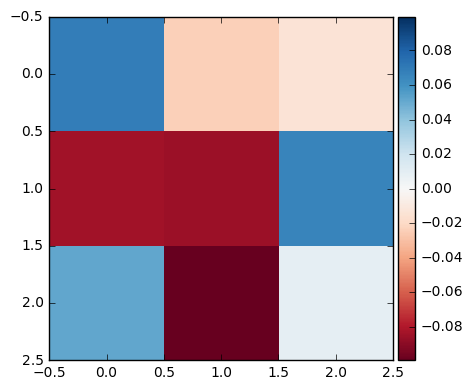

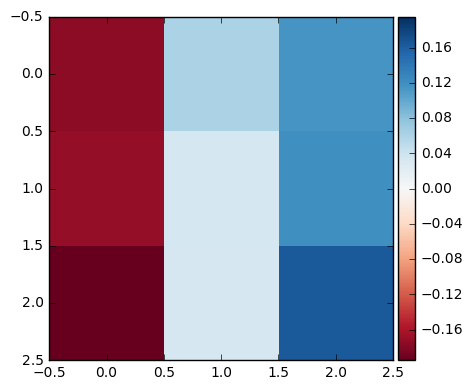

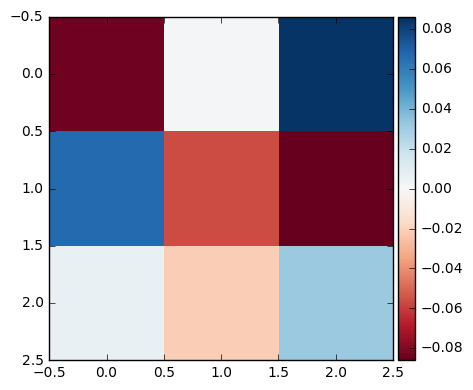

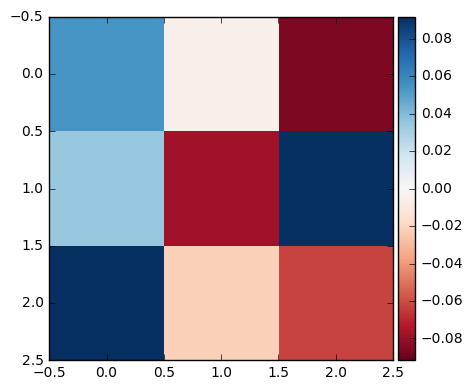

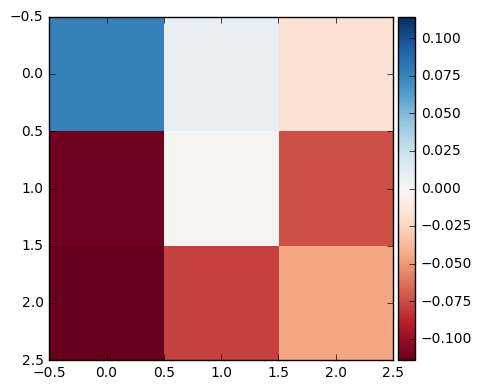

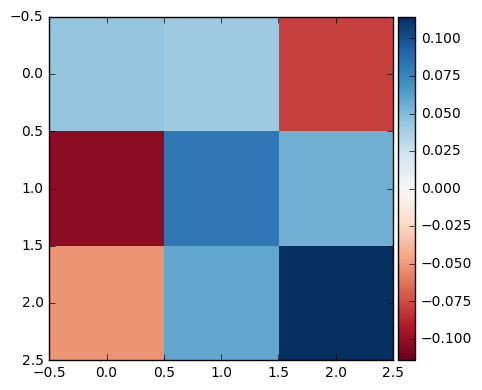

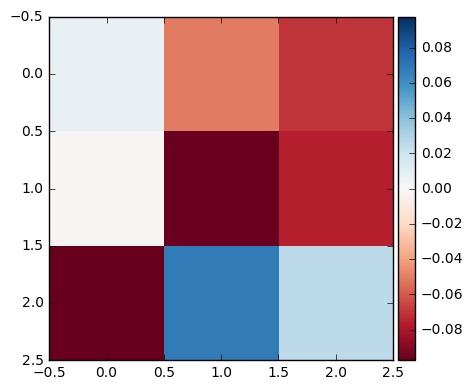

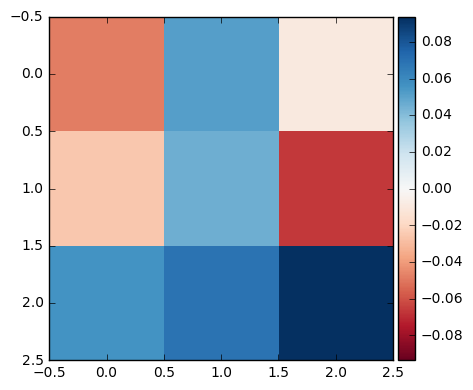

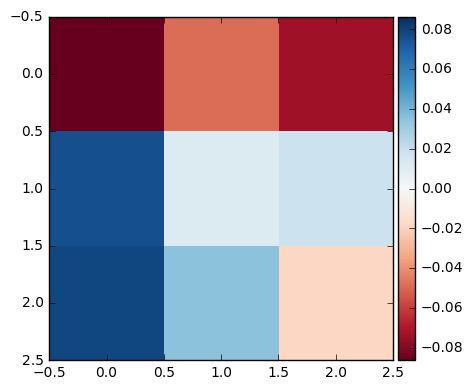

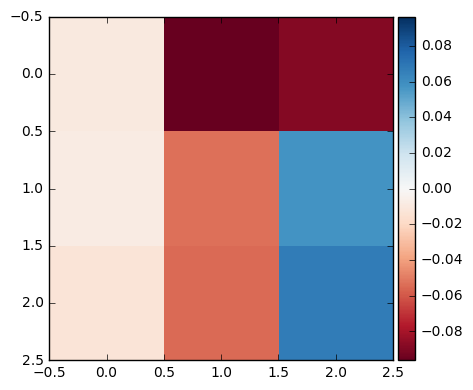

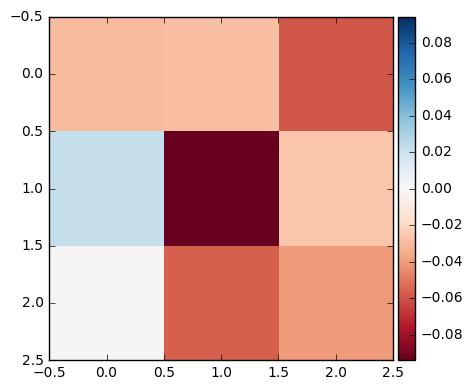

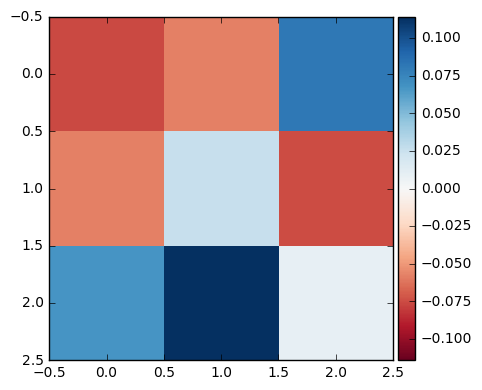

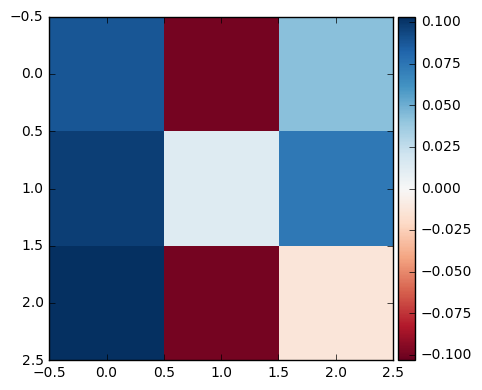

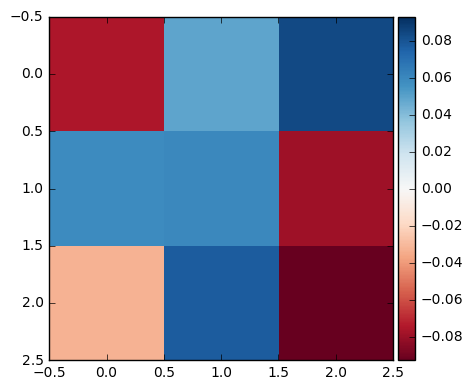

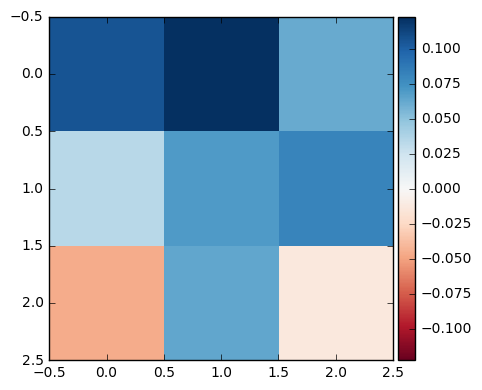

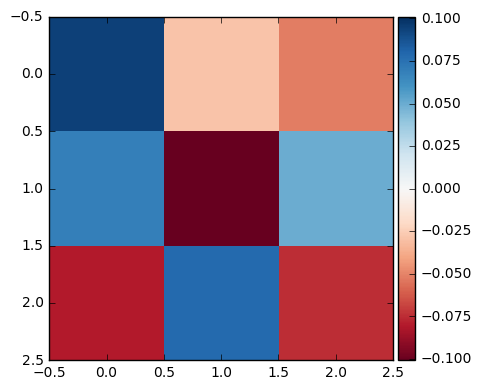

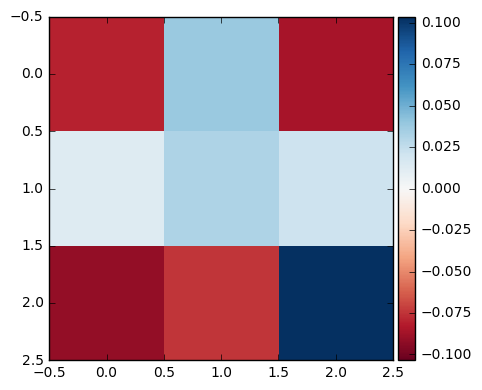

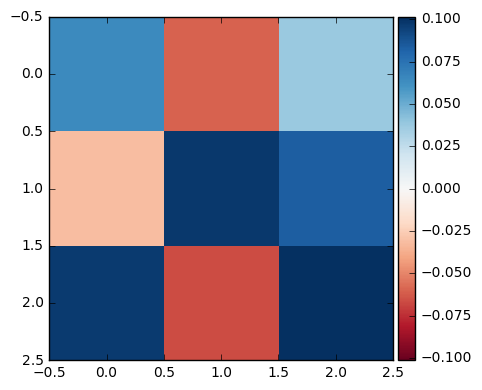

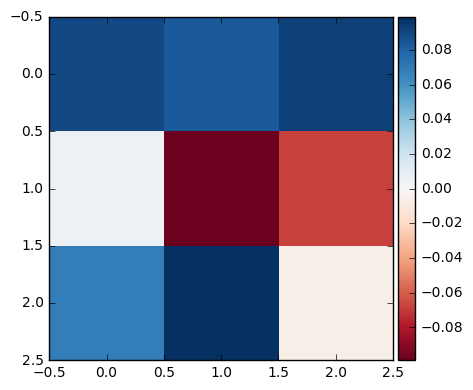

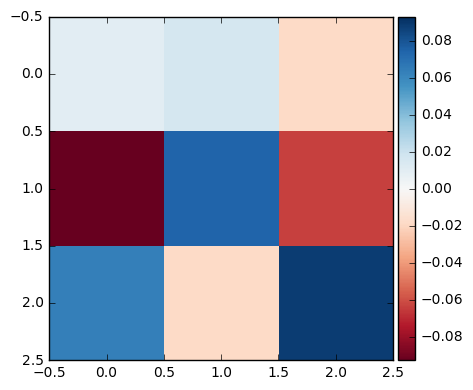

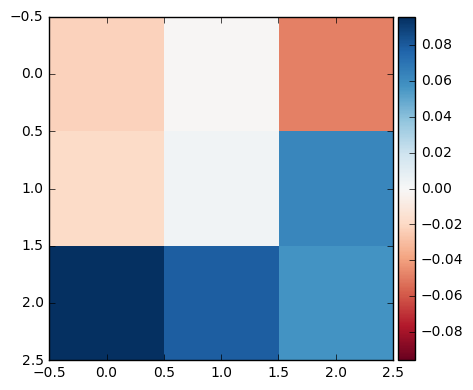

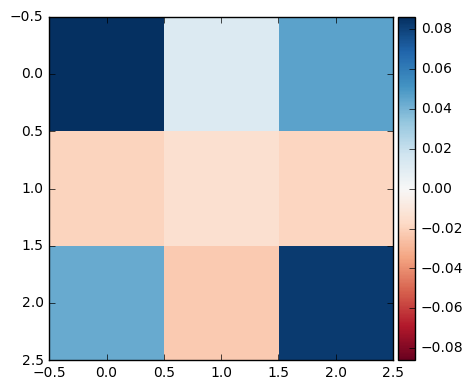

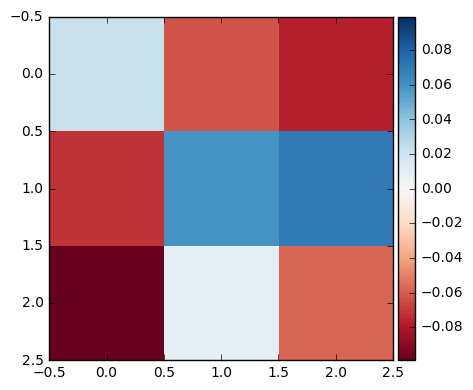

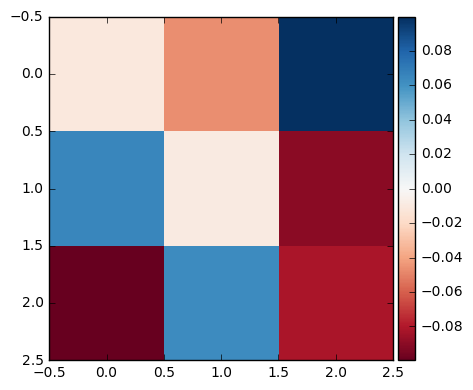

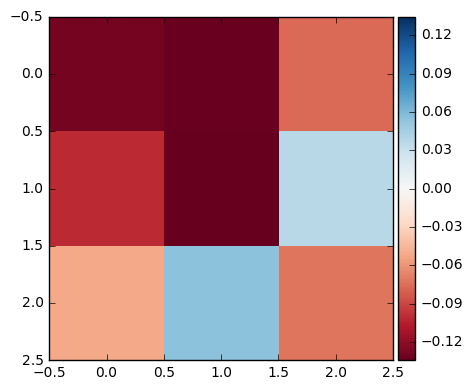

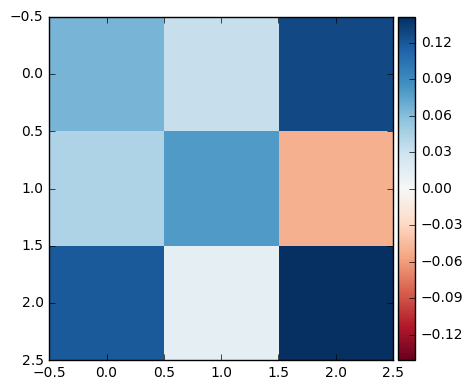

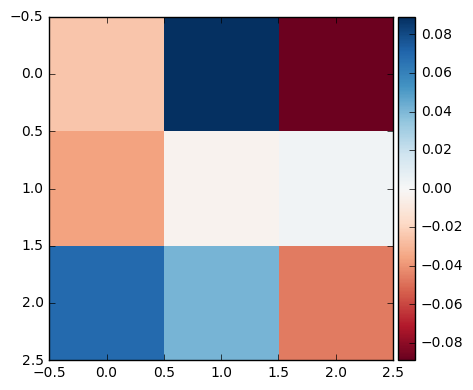

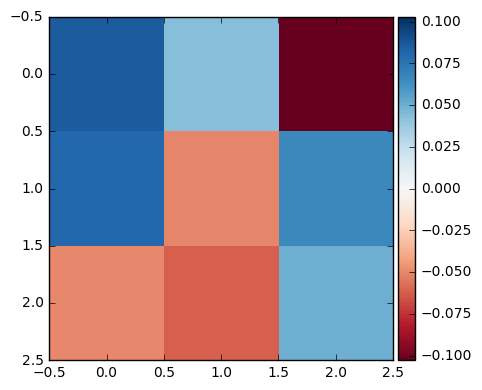

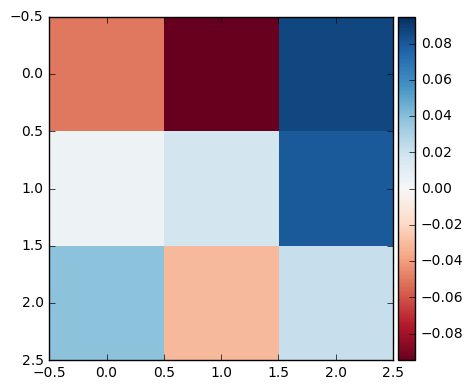

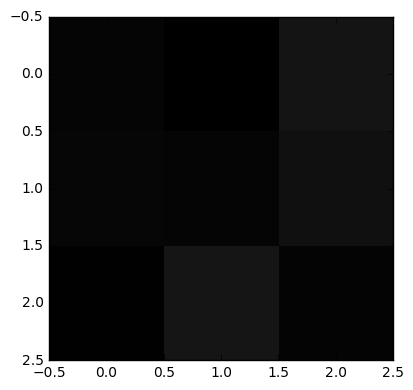

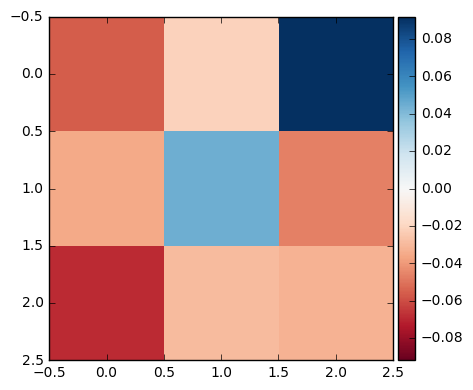

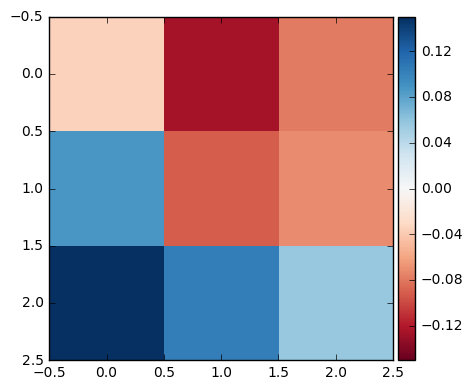

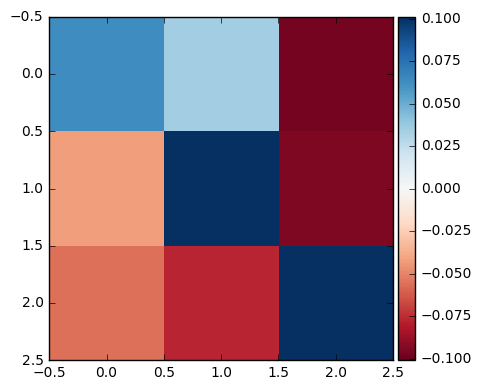

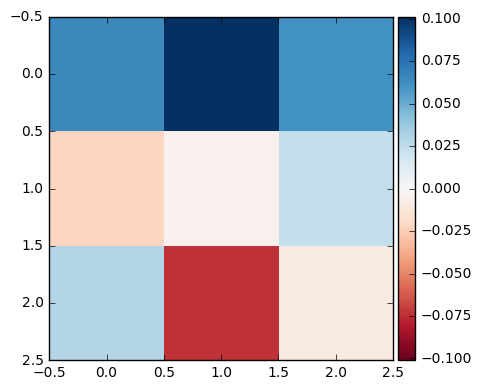

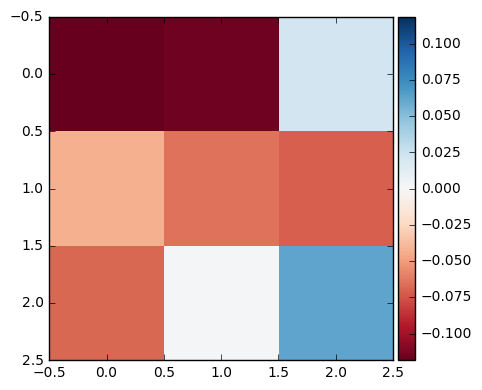

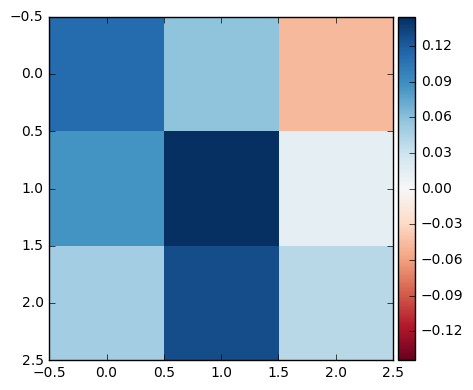

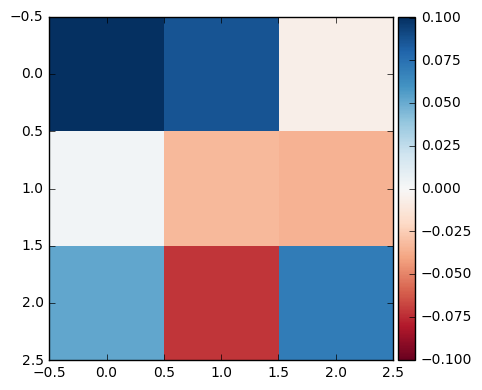

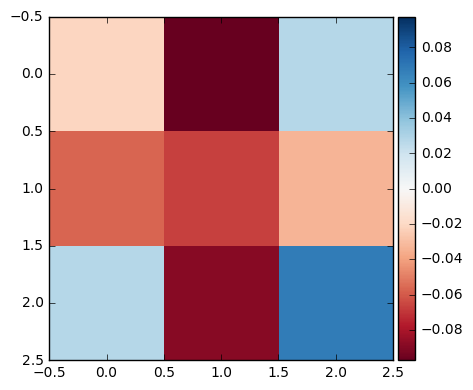

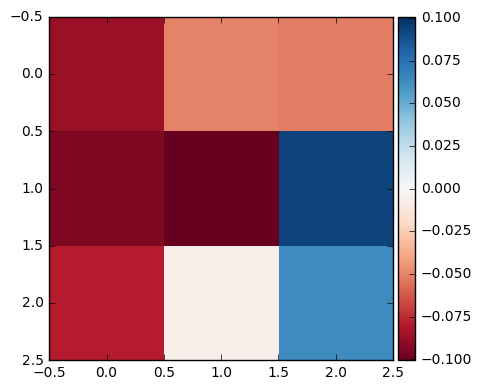

In [312]:
print('Conv')
for i in range(с1_weights.shape[0]):
    for j in range(с1_weights.shape[1]):
        plt.figure()
        io.imshow(с1_weights[i,j].detach().numpy())
        io.show()